# Sequential testing

In [1]:
from scipy.stats import norm
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

Возьмем распределение Вейбулла. Это непрерывное распределение, ограниченное снизу. 

Распределение Вейбулла применяется для описания различных времен жизни при оценке надежности, для описания силы ветра, интенсивности дождя, различных аспектов здравоохранения, прорастания семян, продолжительности простоев в промышленности, мигрирующих систем и характеристик гроз.

$$f_{\eta}(t) = \frac{b}{\eta}\left(\frac{t}{\eta}\right)^{b - 1}\exp\left(-\left(\frac{t}{\eta}\right)^{b}\right)$$

In [2]:
# задается 2 параметрами
eta = 1.5 # описывает scale (растягивает плотность)
b = 1 # описывает форму распределения

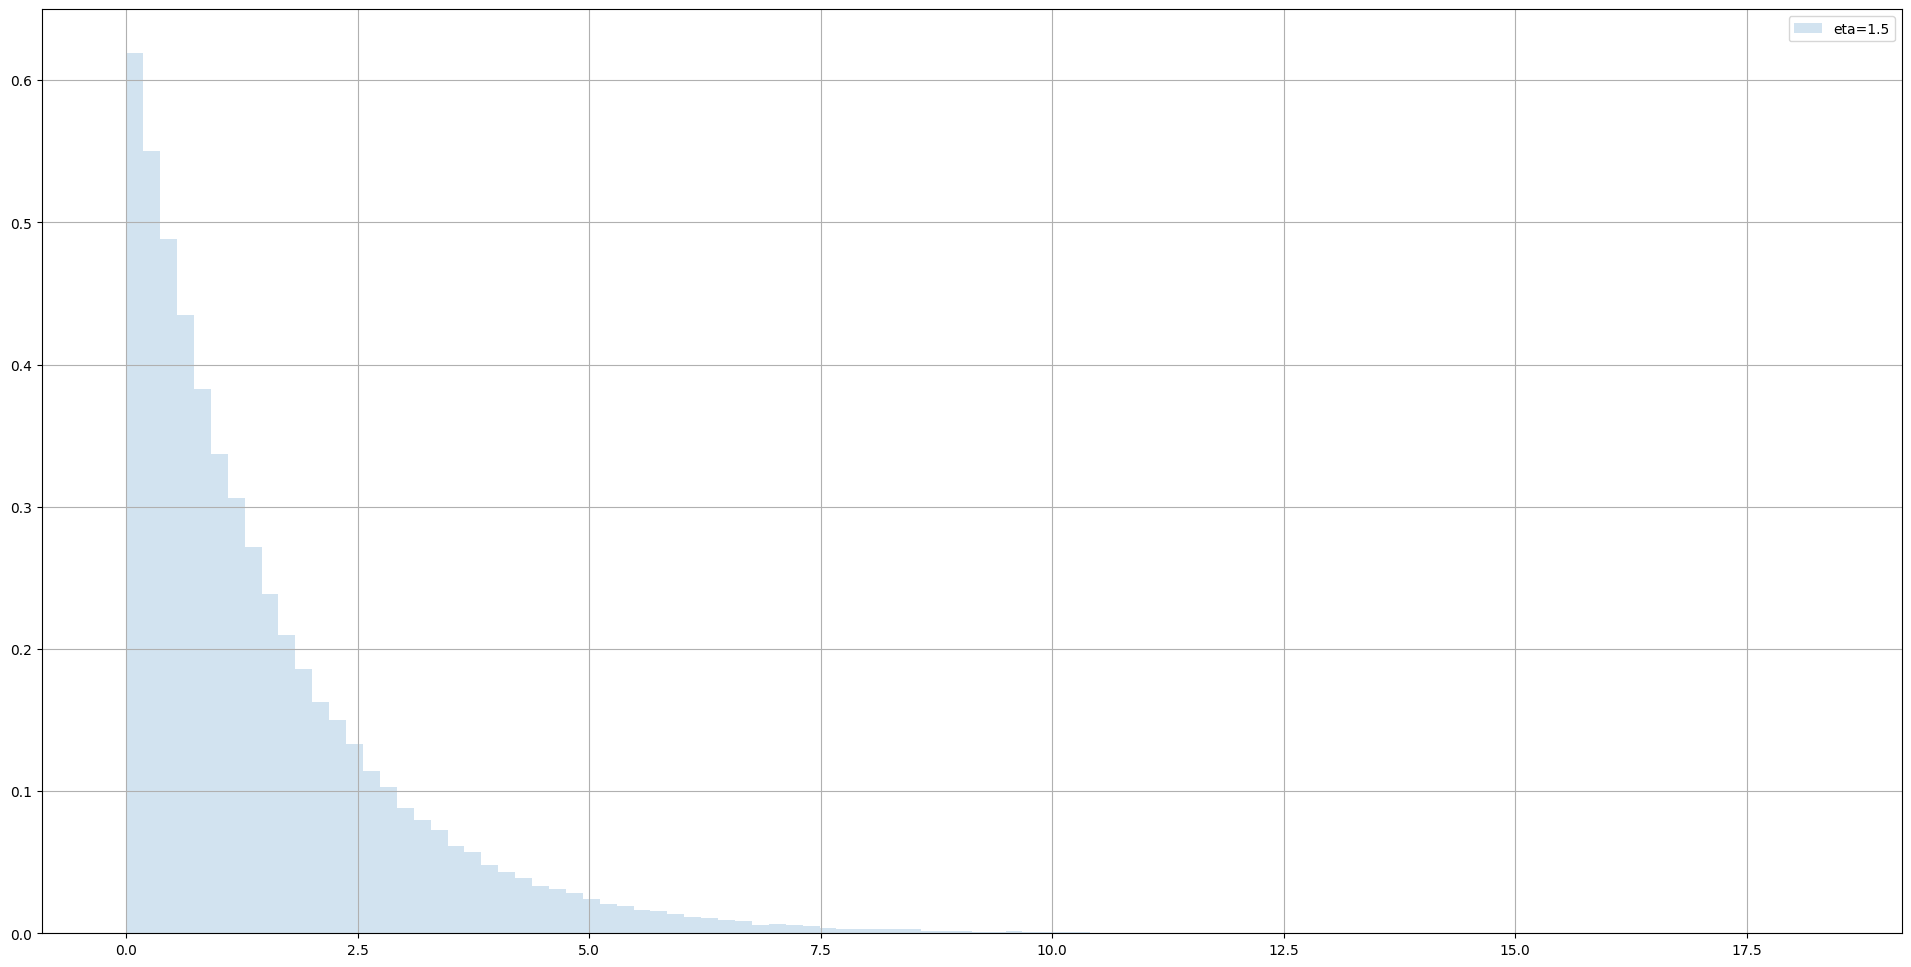

In [3]:
# при b = 1 очень похоже на экспоненциальное распределение

plt.figure(figsize=(24, 12))
plt.hist(eta * np.random.weibull(b, 100000), bins=100, density=True, alpha=0.2, label=f'eta={eta}')
plt.grid()
plt.legend()
plt.show()

### поменяем b (форму)

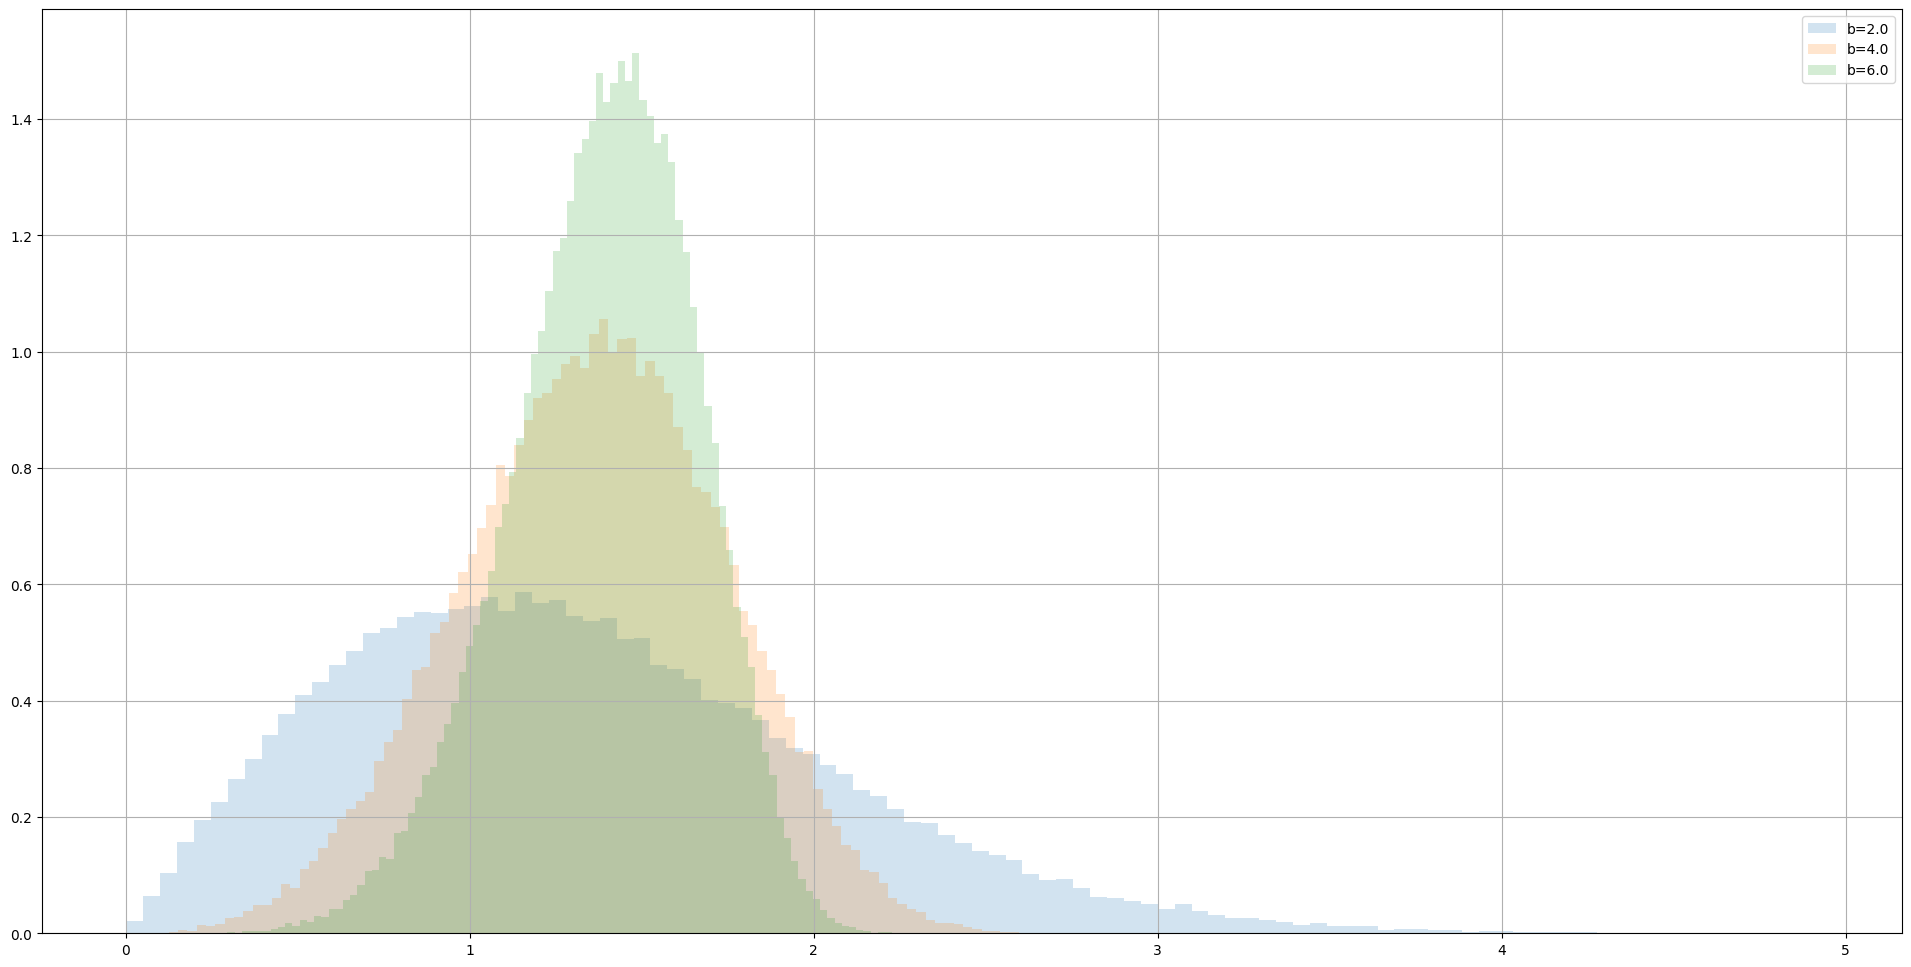

In [4]:
plt.figure(figsize=(24, 12))
for b in np.linspace(2, 6, 3):
    plt.hist(eta * np.random.weibull(b, 100000), bins=100, density=True, alpha=0.2, label=f'b={b}')
plt.grid()
plt.legend()
plt.show()

### Поменяем eta (scale)

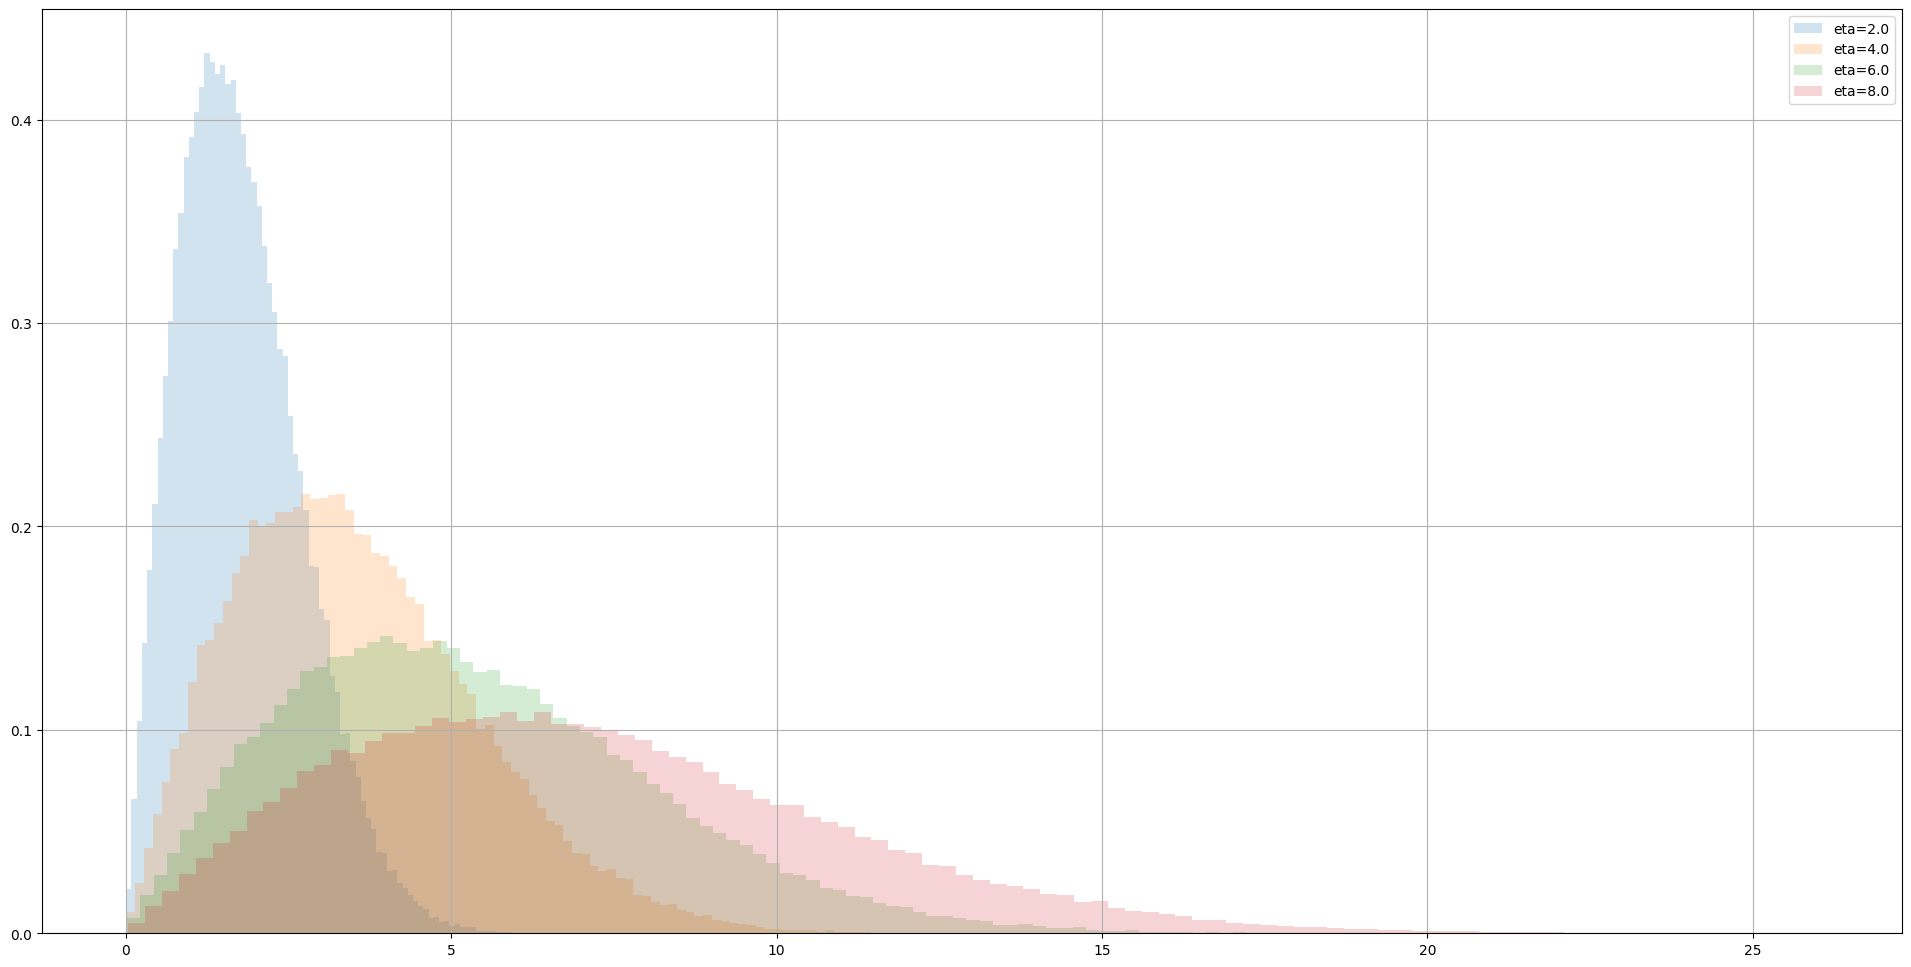

In [5]:
b = 2
plt.figure(figsize=(24, 12))
for eta in np.linspace(2, 8, 4):
    plt.hist(eta * np.random.weibull(b, 100000), bins=100, density=True, alpha=0.2, label=f'eta={eta}')
plt.grid()
plt.legend()
plt.show()

###  Проведем тест

In [6]:
eta1 = 2 # нулевая гипотеза
eta2 = 2.5 # альтернативная
eta_real = 2.1 # полученная по наблюдениям
b = 2.25

alpha = 0.001 # вероятность ошибки 1 рода
beta = 0.0001 # вероятность ошибки 2 рода
n = 10000

In [9]:
data1 = np.random.weibull(b, size=n) * eta_real
counter_acc = 0
L = []
U = []
V = [0]
for i in range(n):
    V.append(V[-1] + data1[i]**b)
    L.append((eta1 * eta2)**b / (eta2**b - eta1**b) * (np.log(beta / (1 - alpha)) + (i + 1) * b * np.log(eta2 / eta1)))
    U.append((eta1 * eta2)**b / (eta2**b - eta1**b) * (np.log((1 - beta) / alpha) + (i + 1) * b * np.log(eta2 / eta1)))
    if V[-1] < L[-1]:
        counter_acc += 1
        break
    if V[-1] > U[-1]:
        break
V = V[1:]

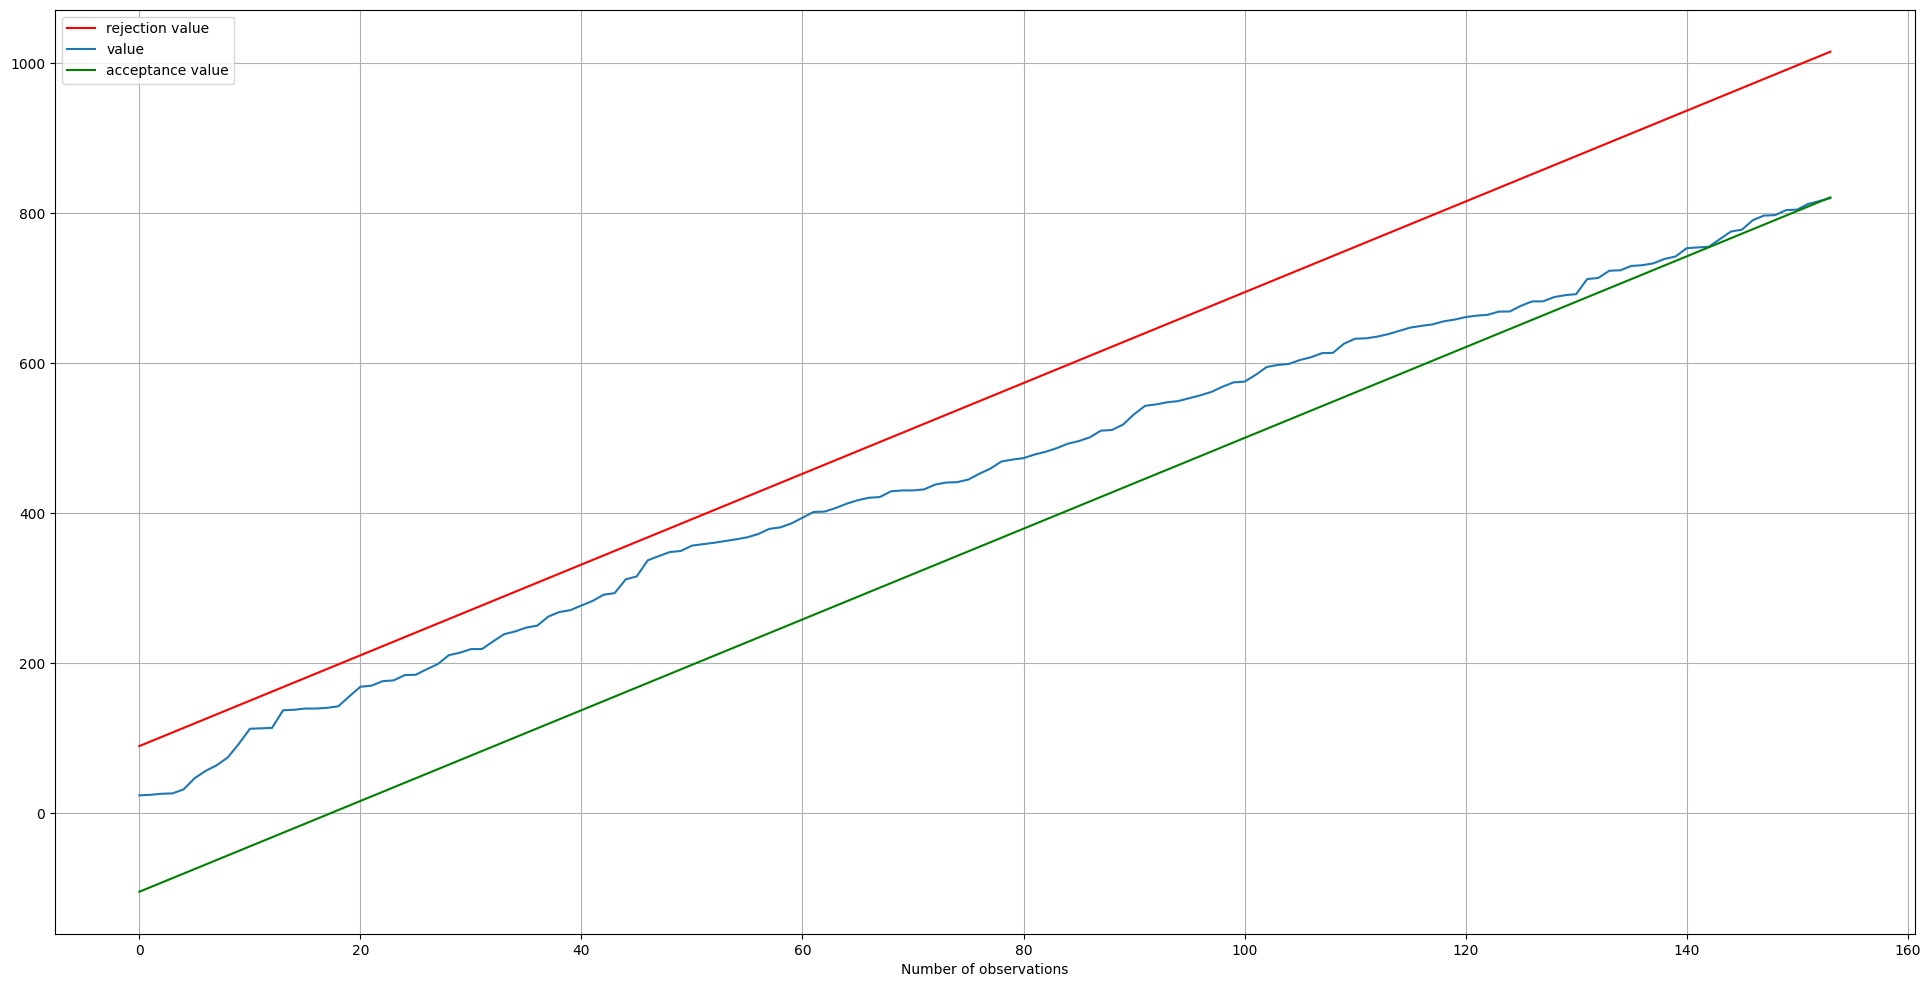

In [10]:
plt.figure(figsize=(24, 12))
plt.plot(U, label='rejection value', c='red')
plt.plot(V, label='value')
plt.plot(L, label='acceptance value', c='green')

plt.xlabel('Number of observations')  # Adding y-axis title
plt.grid()
plt.legend()
plt.show()

### Пусть верна eta 1. Посмотрим на вероятность ошибки 1 рода.



In [14]:
counter_acc = 0
for j in tqdm(range(10000)):
    data1 = np.random.weibull(b, size=n) * eta1 
    L = []
    U = []
    V = [0]
    for i in range(n):
        V.append(V[-1] + data1[i]**b)
        L.append((eta1 * eta2)**b / (eta2**b - eta1**b) * (np.log(beta / (1 - alpha)) + (i + 1) * b * np.log(eta2 / eta1)))
        U.append((eta1 * eta2)**b / (eta2**b - eta1**b) * (np.log((1 - beta) / alpha) + (i + 1) * b * np.log(eta2 / eta1)))
        if V[-1] < L[-1]: # Принимаем H0
            counter_acc += 1
            break
        if V[-1] > U[-1]:
            break
    V = V[1:]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [15]:
# Вероятность ошибки 1 рода
(10000 - counter_acc) / counter_acc

0.0007004903432402681

**Наша О1Р меньше, чем заданный уровень значимости. Тест работает корректно**

#### Пусть верна eta 2. Посмотрим на вероятность ошибки 2 рода

In [17]:
counter_acc = 0
for j in tqdm(range(10000)):
    data1 = np.random.weibull(b, size=n) * eta2
    L = []
    U = []
    V = [0]
    for i in range(n):
        V.append(V[-1] + data1[i]**b)
        L.append((eta1 * eta2)**b / (eta2**b - eta1**b) * (np.log(beta / (1 - alpha)) + (i + 1) * b * np.log(eta2 / eta1)))
        U.append((eta1 * eta2)**b / (eta2**b - eta1**b) * (np.log((1 - beta) / alpha) + (i + 1) * b * np.log(eta2 / eta1)))
        if V[-1] < L[-1]: # принимаем H0
            counter_acc += 1
            break
        if V[-1] > U[-1]:
            break
    V = V[1:]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [18]:
counter_acc / 10000

0.0001

**Наша О2Р приближается к заданной. Тест работает корректно**

## Стратификация

Объявим дф с 3 стратами, где у всех отличается дисперсия и средние

In [37]:
np.random.seed(1123)
treatment_effect = 1

# Объявим дф с 3 стратами, где у всех отличается дисперсия и средние
def gen_data(treatment_effect = 0):

    stratum_1 = pd.DataFrame({"group": "stratum_1", "val": norm.rvs(size=12000, loc=15 + treatment_effect, scale=2)})
    stratum_2 = pd.DataFrame({"group": "stratum_2", "val": norm.rvs(size=6000, loc=20 + treatment_effect, scale=2.5)})
    stratum_3 = pd.DataFrame({"group": "stratum_3", "val": norm.rvs(size=2000, loc=30 + treatment_effect, scale=3)})

    return pd.concat([stratum_1, stratum_2, stratum_3])

df_control = gen_data()
df_control["variant"] = "Control"
df_control["indx"] = df_control.index

df_treatment = gen_data(treatment_effect)
df_treatment["variant"] = "Treatment"
df_treatment["indx"] = df_treatment.index

df_combined = pd.concat([df_control, df_treatment])

<Axes: xlabel='val', ylabel='Count'>

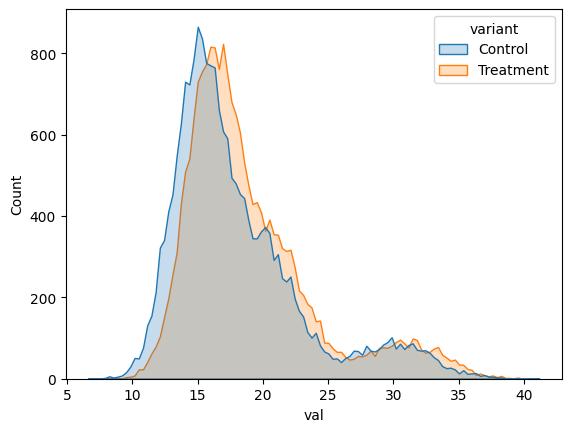

In [38]:
sns.histplot(data=df_combined.reset_index(), x="val", hue="variant", element="poly")

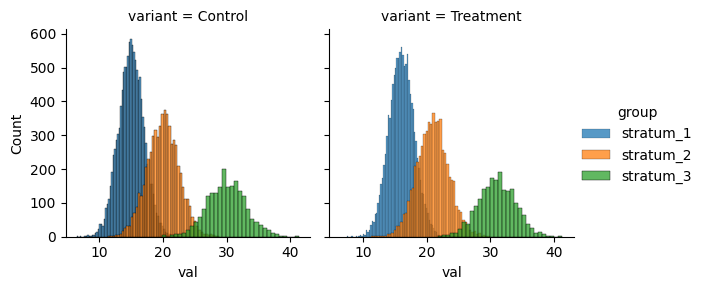

In [39]:
g = sns.FacetGrid(df_combined.reset_index(), col="variant", hue="group")
g.map_dataframe(sns.histplot, x="val")
g.add_legend()

## Считаем средние и дисперсию по двум кейсам: средневзвешенно по стратам и без их учета

### Без страт 

In [40]:
normal_te = pd.DataFrame({
    "effect_estimate": np.mean(df_treatment.val - df_control.val),
    "effect_estimate_se": np.sqrt(np.var(df_treatment.val) / len(df_treatment.val) + np.sqrt(np.var(df_control.val)) / len(df_control.val)),
    "n": len(df_treatment.val) + len(df_control.val)
}, index=[0])
print(normal_te)

   effect_estimate  effect_estimate_se      n
0          0.99308            0.039473  40000


In [41]:
def get_effect_estimate_se(treatment, control):
    return np.sqrt(np.var(treatment) / len(treatment) + np.sqrt(np.var(control)) / len(control))

def get_effect_estimate(treatment, control):
    return np.mean(treatment - control)

### По стратам

In [42]:
groups = {}
for k, group in df_combined.groupby(by="group"):
    cur_df = pd.DataFrame()
    for g, variant in group.groupby(by="variant"):
        cur_df = pd.concat([cur_df, variant])
    groups[k] = cur_df

In [43]:
effect_estimate_se = []
effect_estimate = []
n = []
stratums = []

for key, df in groups.items():
    control = df[df.variant=="Control"]
    treatment = df[df.variant=="Treatment"]
    effect_estimate_se.append(get_effect_estimate_se(treatment.val, control.val))
    effect_estimate.append(get_effect_estimate(treatment.val, control.val))
    n.append(len(df))
    stratums.append(key)
    
strat_te = pd.DataFrame({
    "group": stratums,
    "effect_estimate_se": effect_estimate_se,
    "effect_estimate": effect_estimate,
    "n": n
})

In [44]:
strat_te

,group,effect_estimate_se,effect_estimate,n
0,stratum_1,0.022258,1.014480,24000
1,stratum_2,0.038132,0.944277,12000
2,stratum_3,0.074979,1.011093,4000


##  Взвешенная оценка


Умножаем нашу метрику на вес страты

$$
\frac{n_k}{n} * metric
$$

In [45]:
strat_te["effect_estimate_se"] = strat_te["effect_estimate_se"] * strat_te["n"] / np.sum(strat_te["n"]) 
strat_te["effect_estimate"] = strat_te["effect_estimate"] * strat_te["n"] / np.sum(strat_te["n"])

In [46]:
strat_te

,group,effect_estimate_se,effect_estimate,n
0,stratum_1,0.013355,0.608688,24000
1,stratum_2,0.011440,0.283283,12000
2,stratum_3,0.007498,0.101109,4000


Суммируем по колонкам

In [47]:
strat_te = strat_te[["effect_estimate","effect_estimate_se","n"]].apply("sum")
strat_te

effect_estimate           0.993080
effect_estimate_se        0.032292
n                     40000.000000
dtype: float64

## Результаты

In [48]:
res = (1-(strat_te.effect_estimate_se / normal_te.effect_estimate_se))*100 
print(f"Сокращение дисперсии на {res[0]}%")

Сокращение дисперсии на 18.192384908419747%


In [49]:
pd.DataFrame(strat_te).T

,effect_estimate,effect_estimate_se,n
0,0.99308,0.032292,40000.0


In [50]:
normal_te

,effect_estimate,effect_estimate_se,n
0,0.99308,0.039473,40000
